## Movie Revenue Prediction

In [1]:
%load_ext watermark
%watermark -a "Emily Schoof" -d -t -v -p numpy,pandas,matplotlib,sklearn,nltk

Emily Schoof 2019-08-22 21:07:19 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
pandas 0.24.2
matplotlib 3.0.3
sklearn 0.20.3
nltk 3.4


In [2]:
# Load the dataset
%store -r movie_revenue_ml
%store -r movie_revenue_ml_2
movie_revenue_ml.shape, movie_revenue_ml_2.shape

((4641, 121), (4641, 29))

In [3]:
movie_revenue_ml = movie_revenue_ml.drop(columns='genres')
movie_revenue_ml.head(2)

,title,revenue,original_language,runtime,release_date,release_day_of_week,release_month,action,adventure,animation,...,gb,germany,kingdom,states,united,deutsch,english,espa,fran,italiano
0,6,2.787965e+09,en,162.0,20091210,Thursday,12,1,1,0,...,1,0,1,1,2,0,1,1,0,0
1,7,1.845034e+09,en,194.0,19971118,Tuesday,11,0,0,0,...,0,0,0,1,1,1,1,0,1,1


## Create a Step-by-Step Pipeline

Case 1: Using only top features (made in 3b_feature_engineering) from the nested columns

Case 2: Using all genres, and relying on CountVectorizer (with no labels) to assess other (cleaned) nested columns

_____________________________________________________________________________________________________________________

## Case 1: Using Only Top Features

### Define Target (Movie Revenue *movie_revenue_ml['revenue']*) and Feature Variables

In [4]:
# Import relevent modules
from sklearn.model_selection import train_test_split

In [5]:
# Set up the target variable
y_target = movie_revenue_ml['revenue'].values
print('Target: ', y_target.shape)

# Set the feature variables
X_features = movie_revenue_ml.drop(columns=['revenue'], axis = 1)
feature_list = X_features.columns
print('Features: ', X_features.shape)

Target:  (4641,)
Features:  (4641, 119)


### Preprocessing Data

In [6]:
# Import relevant modules
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
movie_revenue_ml.dtypes

title                    int64
revenue                float64
original_language       object
runtime                float64
release_date             int64
release_day_of_week     object
release_month            int64
action                   int64
adventure                int64
animation                int64
comedy                   int64
crime                    int64
documentary              int64
drama                    int64
family                   int64
fantasy                  int64
fiction                  int64
history                  int64
horror                   int64
music                    int64
mystery                  int64
romance                  int64
science                  int64
thriller                 int64
war                      int64
aftercreditsstinger      int64
base                     int64
biography                int64
car                      int64
child                    int64
                        ...   
new                      int64
paramoun

**Text Columns**

In [8]:
def combine_text_columns(df):
    """ Convert All Values in a Column Into One Vector """
    
    # Replace nulls with empty spaces
    df.fillna('', inplace=True)
    
          # Join all columns into unique vectors
    return df.apply(lambda col: ' '.join(col), axis=1)

In [9]:
text_columns = ['original_language', 'release_day_of_week']
token_alphanumeric = '[A-Za-z0-9]+(?=\\s+)'
X_feature_text = X_features[text_columns]
X_feature_text_vector = combine_text_columns(X_feature_text)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [10]:
# Create a vectorizer instance
vectorizer = CountVectorizer(binary=False, token_pattern=token_alphanumeric)

# build the vocabulary and convert text to a bag of words
X_features_text_transformed = vectorizer.fit_transform(X_feature_text_vector)

In [11]:
X_features_text_transformed.shape

(4641, 37)

**Numerical Values**

In [12]:
numberic_columns = X_features.copy().drop(columns=text_columns).columns
X_feature_numberic = X_features[numberic_columns]
X_feature_numberic.shape

(4641, 129)

**Combine Processed Text and Numerical Features**

In [13]:
# Import Necessary Modules
import numpy as np
from scipy.sparse import hstack

In [14]:
X_features_processed = hstack((X_features_text_transformed, np.array(X_feature_numberic))).toarray()

In [15]:
X_features_processed.shape

(4641, 166)

*Observations*: 165 columns is a not a high dimensional dataset. So, dimensionality reduction does not need to be applied.

### Standard Scale Data

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
# Standarize features
scaler = StandardScaler()

# Fit to data
X_features_scaled = scaler.fit_transform(X_features_processed)

In [18]:
X_features_scaled.shape

(4641, 166)

### Split Data

In [19]:
# Create train and test data sets -> Arbitrary Random State of 42 Set with test/train size of 30/70 (>25% of data)
X_train, X_test, y_train, y_test = train_test_split(X_features_scaled, y_target, test_size=0.3, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

3248 1393 3248 1393


((3248, 166), (1393, 166), (3248,), (1393,))

## Model Selection: Ridge Regression
- Shrink the coefficients and it helps to reduce the model complexity and multi-collinearity
- Higher the alpha value, more restriction on the coefficients
- MSE is a measure of the quality of the estimator while MAE is a measure that returns the weighted average of all output errors

**Determine Best Alpha for Model**

In [20]:
# Import necessary modules
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Create ridge regression with five possible alpha values
potential_alphas = 10**np.linspace(10,-2,100)*0.5

# Create ridgecv instance with potential alphas and 10 cross validations
ridge_cv = RidgeCV(cv=5, alphas=potential_alphas, scoring='neg_mean_absolute_error', normalize=True)

In [22]:
# Fit to entire data
ridge_cv = ridge_cv.fit(X_features_scaled, y_target)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [23]:
ridge_cv.coef_, ridge_cv.coef_.shape

(array([-7.74206950e+02, -2.36671159e+02, -1.00173320e+03, -2.73896040e+02,
        -9.18651719e+02, -1.46357175e+03, -8.50200447e+02,  6.13258190e+03,
        -2.31972939e+03, -6.21295402e+02, -2.89697472e+03, -6.35585696e+02,
        -1.89530556e+03, -2.75023515e+02, -1.17966524e+03, -8.51065609e+02,
        -1.40782487e+03, -6.59461252e+02, -1.34809434e+03, -6.23086169e+01,
        -8.20130723e+02, -9.45099701e+02, -8.35473940e+02, -7.67631469e+02,
        -2.73148166e+02, -8.72043323e+02, -6.39281628e+02, -1.80023775e+03,
        -6.17890823e+01, -5.78420295e+02, -8.79482596e+01, -7.35842274e+01,
        -9.79630748e+02, -2.75259780e+02, -8.45936349e+02, -4.21079889e+02,
        -9.28857778e+02,  8.73461355e+03,  1.94381361e+04,  9.00846834e+03,
         3.28227529e+03,  1.49285708e+04,  2.72360545e+04,  1.62144606e+04,
         1.73958582e+04, -4.31980175e+03, -2.54577432e+02, -5.15547492e+03,
        -3.99156743e+03, -1.40303055e+04,  1.40513954e+04, -1.31115936e+02,
         1.6

In [24]:
# View best alpha for the ridge model
optimal_alpha = round(ridge_cv.alpha_, 4)
optimal_alpha

1882.4679

**Create a Ridge Regression Model**

In [25]:
# Import relevant modules
from sklearn.linear_model import Ridge

In [26]:
# Create a rigde instance with optimal alpha
ridge_reg = Ridge(alpha=optimal_alpha, normalize=True)

# Fit to training data
ridge_reg.fit(X_train, y_train)

Ridge(alpha=1882.4679, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

#### Assess Model Accuracy

In [27]:
# Import metrics modules
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.gofplots import qqplot

*Observations*: Using the standard-scaled features with reduced dimensionality, the large alpha appears to predict movie revenue with relatively high accuracy for both the training and testing datasets.

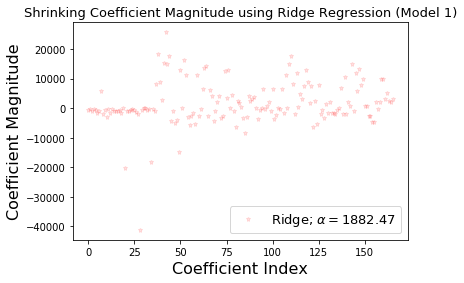

In [28]:
plt.plot(ridge_reg.coef_,alpha=optimal_alpha,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 1882.47$',zorder=7) # zorder for ordering the markers
plt.title('Shrinking Coefficient Magnitude using Ridge Regression (Model 1)',fontsize=13)
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

In [29]:
# Evaluate Model Performance
ridge_y_pred = ridge_reg.predict(X_test)
performance_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': ridge_y_pred.flatten()})
performance_df.head()

,Actual,Predicted
0,2.550002e+08,1.078749e+08
1,3.808578e+07,1.080682e+08
2,1.012778e+08,1.077026e+08
3,3.735521e+08,1.083225e+08
4,1.244940e+05,1.078776e+08


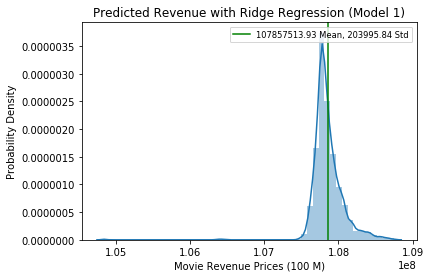

In [30]:
# Plot model
ridge_pred_mean = np.mean(ridge_y_pred)
ridge_pred_std = np.std(ridge_y_pred)
sns.distplot(ridge_y_pred)
plt.axvline(x=ridge_pred_mean, color='green', label='{0:2.2f} Mean, {1:2.2f} Std'.format(ridge_pred_mean, ridge_pred_std))
plt.legend(fontsize = 'small', loc='upper right')
plt.title("Predicted Revenue with Ridge Regression (Model 1)")
plt.xlabel("Movie Revenue Prices (100 M)")
plt.ylabel("Probability Density")
plt.show()

In [31]:
# Calculate the mean squared errors -TRAIN-
rr_mean_squ_error = mean_squared_error(y_train, ridge_reg.predict(X_train))
rr_mean_abs_error = mean_absolute_error(y_train, ridge_reg.predict(X_train))
print("Ridge Regression training mse=$", round(rr_mean_squ_error, 2)," & rmse=$", round(sqrt(rr_mean_squ_error),2))
print("Ridge Regression training mae=$", round(rr_mean_abs_error, 2))

Ridge Regression training mse=$ 2.491123689796506e+16  & rmse=$ 157832939.84
Ridge Regression training mae=$ 84122945.62


In [32]:
# Calculate the mean squared errors -TEST-
rr_test_mean_squ_error = mean_squared_error(y_test, ridge_reg.predict(X_test))
rr_test_mean_abs_error = mean_absolute_error(y_test, ridge_reg.predict(X_test))
print("Ridge Regression testing mse=$", round(rr_test_mean_squ_error, 2)," & rmse=$", round(sqrt(rr_test_mean_squ_error),2))
print("Ridge Regression testing mae=$", round(rr_test_mean_abs_error, 2))

Ridge Regression testing mse=$ 2.358697770992425e+16  & rmse=$ 153580525.16
Ridge Regression testing mae=$ 86451606.33


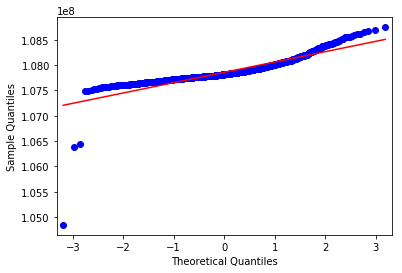

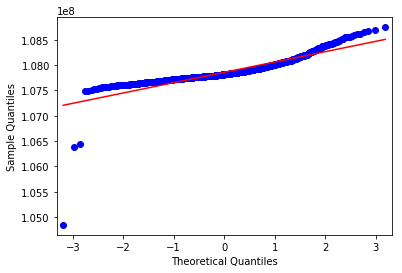

In [33]:
qqplot(ridge_y_pred, line='s')

**Conclusion**: Model 1 appears to predict unseen data within a **mean absolute error of ~86 million** with decreased accuracy as the tendancy to over-estimate large values that exceed quantile 2. Since the mean absolute error of the training set is also approximately **mean absolute error of ~84 million**, the model did not overfit on the training data.

_____________________________________________________________________________________________________________________

## Case 2: Using all genres, and relying on CountVectorizer (with no labels) to assess other (cleaned) nested columns

In [34]:
# Set up the target variable
y_target_2 = movie_revenue_ml_2['revenue'].values
print('Target: ', y_target_2.shape)

# Set the feature variables
X_features_2 = movie_revenue_ml_2.drop(columns=['revenue'], axis = 1)
feature_list_2 = X_features_2.columns
print('Features: ', X_features_2.shape)

Target:  (4641,)
Features:  (4641, 28)


In [35]:
X_features_2.dtypes

title                     int64
keywords                 object
original_language        object
production_companies     object
production_countries     object
runtime                 float64
spoken_languages         object
release_date              int64
release_day_of_week      object
release_month             int64
action                    int64
adventure                 int64
animation                 int64
comedy                    int64
crime                     int64
documentary               int64
drama                     int64
family                    int64
fantasy                   int64
fiction                   int64
history                   int64
horror                    int64
music                     int64
mystery                   int64
romance                   int64
science                   int64
thriller                  int64
war                       int64
dtype: object

In [36]:
text_columns_2 = ['keywords', 'original_language', 'production_companies',
                'production_countries', 'release_day_of_week', 'spoken_languages']
X_feature_text_2 = X_features_2[text_columns_2]
X_feature_text_vector_2 = combine_text_columns(X_feature_text_2)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [37]:
# Fit to sampe Vectorizer model and build the vocabulary and convert text to a bag of words
X_features_text_transformed_2 = vectorizer.fit_transform(X_feature_text_vector_2)
X_features_text_transformed_2.shape

(4641, 10672)

In [38]:
numberic_columns_2 = X_features_2.copy().drop(columns=text_columns_2).columns
X_feature_numberic_2 = X_features_2[numberic_columns_2]
X_feature_numberic_2.shape

(4641, 22)

In [39]:
X_features_processed_2 = hstack((X_features_text_transformed_2, np.array(X_feature_numberic_2))).toarray()

In [40]:
X_features_processed_2.shape

(4641, 10694)

*Observations*: 10694 columns is a not a high dimensional dataset. Since purley running any model on this dataset would be time-intensive, a dimensionality reduction method needs to be applied. Singular Value Decomposition (SVD) is popular in the field of natural language processing to achieve a representation of the gigantic while sparse word frequency matrices.

#### Apply SVD to Features

In [41]:
# Import relevant modules
from sklearn.decomposition import TruncatedSVD

**WARNING: SLOW-RUNNING CELL**

In [42]:
# Create an SVD instance with ~1/3 n_components
tsvd = TruncatedSVD(n_components=3565, random_state=42)

# Fit SVD to X_features_processed
X_features_svd = tsvd.fit_transform(X_features_processed_2)

In [43]:
# Sum explained variances to assess if the reduced features capture the variability in the data
tsvd_var_ratios = tsvd.explained_variance_ratio_.sum()
tsvd_var_ratios, X_features_svd.shape

(0.9999999999860582, (4641, 3565))

#### Scale Data

In [44]:
# Fit to same scaler instance
X_features_scaled_2 = scaler.fit_transform(X_features_svd)

#### Split Data

In [45]:
# Create train and test data sets -> Arbitrary Random State of 42 Set with test/train size of 30/70 (>25% of data)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_features_scaled_2, y_target_2, test_size=0.3, random_state=42)
print(len(X_train_2), len(X_test_2), len(y_train_2), len(y_test_2))
X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape 

3248 1393 3248 1393


((3248, 3565), (1393, 3565), (3248,), (1393,))

**WARNING: SLOW-RUNNING CELL**

In [46]:
# Create ridge regression with five possible alpha values
potential_alphas_2 = 10**np.linspace(10,-2,100)*0.5

# Create ridgecv instance with potential alphas and 10 cross validations
ridge_cv_2 = RidgeCV(cv=5, alphas=potential_alphas_2, scoring='neg_mean_absolute_error', normalize=True)

# Fit to entire data
ridge_cv_2 = ridge_cv.fit(X_features_scaled_2, y_target_2)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Define Best Alpha

In [47]:
ridge_cv_2.coef_, ridge_cv_2.coef_.shape

(array([ 4702153.13034601, 13314078.10582257,  6414334.56949563, ...,
          -16703.65161867,  -319668.43104113,  -539242.95222957]), (3565,))

In [ ]:
inverse_ridge_cv = 

In [80]:
# View best alpha for the ridge model
optimal_alpha_2 = round(ridge_cv_2.alpha_, 4)
optimal_alpha_2

1.7556

#### Apply Ridge

In [94]:
# Create a rigde instance with optimal alpha
ridge_reg_2 = Ridge(alpha=(optimal_alpha_2*4), normalize=True)

# Fit to training data
ridge_reg_2.fit(X_train_2, y_train_2)

Ridge(alpha=7.0224, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

#### Assess Model Accuracy

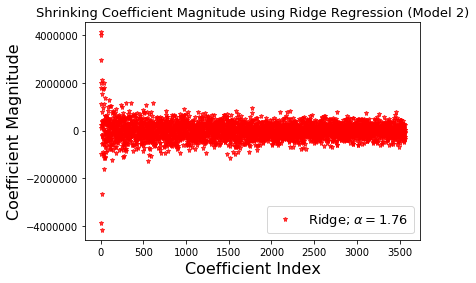

In [95]:
plt.plot(ridge_reg_2.coef_,alpha=optimal_alpha_2,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 1.76$',zorder=7) # zorder for ordering the markers
plt.title('Shrinking Coefficient Magnitude using Ridge Regression (Model 2)',fontsize=13)
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

In [96]:
# Evaluate Model Performance
ridge_y_pred_2 = ridge_reg_2.predict(X_test_2)
performance_df = pd.DataFrame({'Actual': y_test_2.flatten(), 'Predicted': ridge_y_pred_2.flatten()})

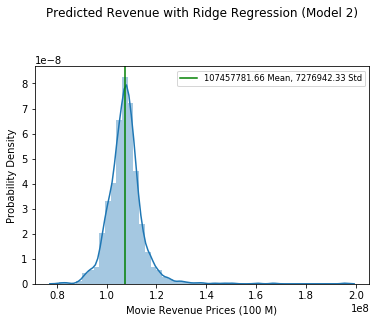

In [106]:
# Plot model
ridge_pred_mean_2 = np.mean(ridge_y_pred_2)
ridge_pred_std_2 = np.std(ridge_y_pred_2)
sns.distplot(ridge_y_pred_2)
plt.axvline(x=ridge_pred_mean_2, color='green', label='{0:2.2f} Mean, {1:2.2f} Std'.format(ridge_pred_mean_2, ridge_pred_std_2))
plt.legend(fontsize = 'small', loc='upper right')
plt.title("Predicted Revenue with Ridge Regression (Model 2)", y=1.2)
plt.xlabel("Movie Revenue Prices (100 M)")
plt.ylabel("Probability Density")
plt.show()

In [107]:
# Calculate the mean squared errors -TRAIN-
rr_mean_squ_error_2 = mean_squared_error(y_train_2, ridge_reg_2.predict(X_train_2))
rr_mean_abs_error_2 = mean_absolute_error(y_train_2, ridge_reg_2.predict(X_train_2))
print("Ridge Regression training mse=$", round(rr_mean_squ_error_2, 2)," & rmse=$", round(sqrt(rr_mean_squ_error_2),2))
print("Ridge Regression training mae=$", round(rr_mean_abs_error_2, 2))

# Calculate the mean squared errors -TEST-
rr_test_mean_squ_error_2 = mean_squared_error(y_test_2, ridge_reg_2.predict(X_test_2))
rr_test_mean_abs_error_2 = mean_absolute_error(y_test_2, ridge_reg_2.predict(X_test_2))
print("Ridge Regression testing mse=$", round(rr_test_mean_squ_error_2, 2)," & rmse=$", round(sqrt(rr_test_mean_squ_error_2),2))
print("Ridge Regression testing mae=$", round(rr_test_mean_abs_error_2, 2))

Ridge Regression training mse=$ 1.780212129826301e+16  & rmse=$ 133424590.31
Ridge Regression training mae=$ 71299088.56
Ridge Regression testing mse=$ 2.309296661504413e+16  & rmse=$ 151963701.64
Ridge Regression testing mae=$ 85303226.23


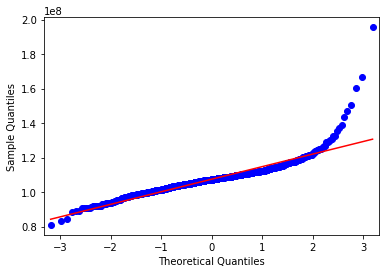

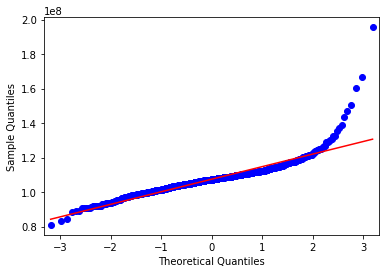

In [99]:
qqplot(ridge_y_pred_2, line='s')